In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import warnings
import lightgbm as lgb
import matplotlib.pyplot as plt
import time

from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve, plot_roc_curve

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN 
 
warnings.filterwarnings('ignore')

start = time.time()

In [21]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
       

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [22]:
application = pd.read_csv('appIication_train.csv')
data = reduce_mem_usage(application)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [23]:
def split_train(data,test_ratio):
   #  data = data.iloc[0:20000,:]
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [24]:
train_app, test_app = split_train(data, 0.2)
print(train_app.shape)
print(test_app.shape)
all_data_x = data.drop(['TARGET','SK_ID_CURR'],axis = 1)
all_data_y = data.loc[:,['TARGET']].values

train_app_x = train_app.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_app_y = train_app.loc[:,['TARGET']].values

test_app_x = test_app.drop(['TARGET','SK_ID_CURR'],axis = 1)
test_app_y = test_app['TARGET'].values

(246009, 122)
(61502, 122)


In [25]:
types = np.array([z for z in all_data_x.dtypes])
all_columns = all_data_x.columns.values                
is_num = types != 'object'  
# is_num = np.array([str(x)[:1] != 'c' for x in types]) 
num_features = all_columns[is_num].tolist()         
cat_features = all_columns[~is_num].tolist() 
features = num_features + cat_features
Pipe_num = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'mean')),        # tried median, mean, constant strategies
    ('scaler', StandardScaler()) ])

Pipe_cat = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('onehot', OneHotEncoder())        ])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipe_num, num_features),
        ('cat', Pipe_cat, cat_features)])
    
preprocessor.fit(data[features])

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY',
                                  'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                                  'FLAG_MOBIL', 'FLAG_EMP_PHONE',
                                  'FLAG_WORK_PHONE'...
                                                                strategy='constant')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                  'FL

In [26]:
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

In [27]:
def lightgbm(X_train, y_train,X_test,y_test):
    gbm = lgb.LGBMClassifier()
    
    print("训练开始")
    gbm = gbm.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = gbm.predict(X_test)

    print("训练集精确度:{%.4f}    "%gbm.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%gbm.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, gbm.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,gbm.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("gbm 的KS:{%.4f}"%ks)
    return gbm

# 元数据

In [28]:
X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
print(X_train.shape)

(246009, 250)


In [29]:
gbm1 = lightgbm(X_train, y_train,X_test,y_test)

训练开始
训练结束
训练集精确度:{0.9197}     测试集精确度:{0.9189}    

predict_proba 训练集auc:{0.7757}  训练集auc:{0.7229}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56523
           1       0.41      0.00      0.01      4979

    accuracy                           0.92     61502
   macro avg       0.67      0.50      0.48     61502
weighted avg       0.88      0.92      0.88     61502

gbm 的KS:{0.3285}


# 随机下采样

In [30]:
# Class count
count_class_0, count_class_1 = train_app.TARGET.value_counts()
print('count_class_0:',count_class_0)
print('count_class_1:',count_class_1)

# Divide by class 分开样本
df_class_0 = train_app[train_app['TARGET'] == 0]
df_class_1 = train_app[train_app['TARGET'] == 1]

# 下采样，采样个数为count_class_1: 24825
df_class_0_under = df_class_0.sample(count_class_1)
# 采样过后，进行合并
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df_test_under.TARGET.value_counts())

count_class_0: 226163
count_class_1: 19846
Random under-sampling:
0    19846
1    19846
Name: TARGET, dtype: int64


In [31]:
X_train = df_test_under.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
X_train = preprocessor.transform(X_train[features])
y_train = df_test_under['TARGET'].values

In [32]:
gbm2 = lightgbm(X_train, y_train,X_test,y_test)

训练开始
训练结束
训练集精确度:{0.7199}     测试集精确度:{0.6711}    

predict_proba 训练集auc:{0.7988}  训练集auc:{0.7206}

classification_report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56523
           1       0.15      0.65      0.24      4979

    accuracy                           0.67     61502
   macro avg       0.55      0.66      0.52     61502
weighted avg       0.89      0.67      0.75     61502

gbm 的KS:{0.3258}


# 下采样：Tomek links

In [33]:
X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y

tl = TomekLinks(sampling_strategy='auto', n_jobs = -1)
tl.fit(X_train, y_train)
# X_train, y_train = tl.fit_resample(X_train, y_train)  # 生成样本时间太久

TomekLinks(n_jobs=-1)

In [34]:
train_tl = train_app.iloc[0:100000, :]
X_train = train_tl.drop(['TARGET','SK_ID_CURR'],axis = 1)
X_train = preprocessor.transform(X_train[features])
y_train = train_tl.loc[:,['TARGET']].values
X_train, y_train = tl.fit_resample(X_train, y_train)

In [35]:
print('Tomek links dataset shape %s' % Counter(y_train.tolist()))

Tomek links dataset shape Counter({0: 90065, 1: 7944})


In [36]:
gbm3 = lightgbm(X_train, y_train,X_test,y_test)

训练开始
训练结束
训练集精确度:{0.9206}     测试集精确度:{0.9190}    

predict_proba 训练集auc:{0.8349}  训练集auc:{0.7160}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56523
           1       0.48      0.01      0.02      4979

    accuracy                           0.92     61502
   macro avg       0.70      0.50      0.49     61502
weighted avg       0.88      0.92      0.88     61502

gbm 的KS:{0.3196}


# CondensedNearestNeighbour: 下采样 采样速度慢

In [63]:
from imblearn.under_sampling import CondensedNearestNeighbour 

X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y


cnn = CondensedNearestNeighbour(random_state=42, n_jobs = -1)
cnn.fit(X_train, y_train)

train_cnn = train_app.iloc[0:10000, :]
train_cnn_x = train_cnn.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_cnn_y = train_cnn.loc[:,['TARGET']].values

# train_cnn_x = train_app.drop(['TARGET','SK_ID_CURR'],axis = 1)
# train_cnn_y = train_app.loc[:,['TARGET']].values


X_train_cnn = preprocessor.transform(train_cnn_x[features])
y_train_cnn = train_cnn_y

X_train, y_train = cnn.fit_resample(X_train_cnn, y_train_cnn)
test = y_train.reshape(y_train.shape[0],)

print('Tomek links dataset shape %s' % Counter(test))

Tomek links dataset shape Counter({0: 2439, 1: 823})


In [64]:
gbm4 = lightgbm(X_train, y_train,X_test,y_test)

训练开始
训练结束
训练集精确度:{0.9739}     测试集精确度:{0.8897}    

predict_proba 训练集auc:{0.9994}  训练集auc:{0.6487}

classification_report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     56523
           1       0.20      0.12      0.15      4979

    accuracy                           0.89     61502
   macro avg       0.56      0.54      0.55     61502
weighted avg       0.87      0.89      0.88     61502

gbm 的KS:{0.2196}


# EditedNearestNeighbours

In [40]:
from imblearn.under_sampling import EditedNearestNeighbours 

X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y


enn = EditedNearestNeighbours(n_neighbors=5, n_jobs = -1)
enn.fit(X_train, y_train)

train_enn = train_app.iloc[0:20000, :]
train_enn_x = train_enn.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_enn_y = train_enn.loc[:,['TARGET']].values
X_train_enn = preprocessor.transform(train_enn_x[features])
y_train_enn = train_enn_y

X_enn, y_enn = enn.fit_resample(X_train_enn, y_train_enn)
test = y_enn.reshape(y_enn.shape[0],)

print('Tomek links dataset shape %s' % Counter(test))

Tomek links dataset shape Counter({0: 12442, 1: 1626})


In [42]:
gbm5 = lightgbm(X_enn, y_enn,X_test,y_test)

训练开始
训练结束
训练集精确度:{0.9267}     测试集精确度:{0.9061}    

predict_proba 训练集auc:{0.9761}  训练集auc:{0.6958}

classification_report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56523
           1       0.27      0.09      0.14      4979

    accuracy                           0.91     61502
   macro avg       0.60      0.54      0.54     61502
weighted avg       0.87      0.91      0.88     61502

gbm 的KS:{0.2909}


# 随机过采样

In [43]:
X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y

ros = RandomOverSampler(random_state=42)
ros.fit(X_train, y_train)
test = y_train.reshape(y_train.shape[0],)

print('Original dataset shape %s' % Counter(test))

X_train, y_train = ros.fit_resample(X_train, y_train)

test = y_train.reshape(y_train.shape[0],)

print('Over-resample dataset shape %s' % Counter(test))

Original dataset shape Counter({0: 226163, 1: 19846})
Over-resample dataset shape Counter({1: 226163, 0: 226163})


In [44]:
gbm6 = lightgbm(X_train, y_train, X_test, y_test)

训练开始
训练结束
训练集精确度:{0.6977}     测试集精确度:{0.6905}    

predict_proba 训练集auc:{0.7728}  训练集auc:{0.7246}

classification_report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56523
           1       0.15      0.63      0.25      4979

    accuracy                           0.69     61502
   macro avg       0.56      0.66      0.53     61502
weighted avg       0.89      0.69      0.76     61502

gbm 的KS:{0.3374}


# SMOTE 过采样

In [45]:
X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

sm = SMOTE(random_state=42)
sm.fit(X_train, y_train)
test = y_train.reshape(y_train.shape[0],)

print('Original dataset shape %s' % Counter(test))

X_train, y_train = sm.fit_resample(X_train, y_train)

test = y_train.reshape(y_train.shape[0],)

print('SMOTE dataset shape %s' % Counter(test))

Original dataset shape Counter({0: 226163, 1: 19846})
SMOTE dataset shape Counter({1: 226163, 0: 226163})


In [46]:
gbm7 = lightgbm(X_train, y_train, X_test, y_test)

训练开始
训练结束
训练集精确度:{0.9557}     测试集精确度:{0.9188}    

predict_proba 训练集auc:{0.9771}  训练集auc:{0.7184}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56523
           1       0.41      0.01      0.01      4979

    accuracy                           0.92     61502
   macro avg       0.66      0.50      0.48     61502
weighted avg       0.88      0.92      0.88     61502

gbm 的KS:{0.3179}


# 综合采样

In [47]:
train_smt, test_smt = split_train(data,0.2)
# ex_test = test_smt.sample(frac=0.20, axis = 0)
# train_smt_l = train_smt.iloc[ex_test.shape[0]:train_smt.shape[0], :]
# train_smt = pd.concat([train_smt_l, ex_test])

train_app_x = train_smt.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_app_y = train_smt.loc[:,['TARGET']].values


X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y


smt = SMOTETomek(random_state=42)
smt.fit(X_train, y_train)

SMOTETomek(random_state=42)

In [59]:
print('Original dataset shape %s' % Counter(train_app["TARGET"]))
X_train, y_train = smt.fit_resample(X_train, y_train)
test = y_train.reshape(y_train.shape[0],)

print('SMOTE + Tomek links dataset shape %s' % Counter(test))

Original dataset shape Counter({0: 226163, 1: 19846})
SMOTE + Tomek links dataset shape Counter({0: 226174, 1: 226174})


In [60]:
gbm8 = lightgbm(X_train, y_train, X_test, y_test)

训练开始
训练结束
训练集精确度:{0.9555}     测试集精确度:{0.9191}    

predict_proba 训练集auc:{0.9773}  训练集auc:{0.7373}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56523
           1       0.51      0.01      0.01      4979

    accuracy                           0.92     61502
   macro avg       0.71      0.50      0.49     61502
weighted avg       0.89      0.92      0.88     61502

gbm 的KS:{0.3479}


<Figure size 1296x576 with 0 Axes>

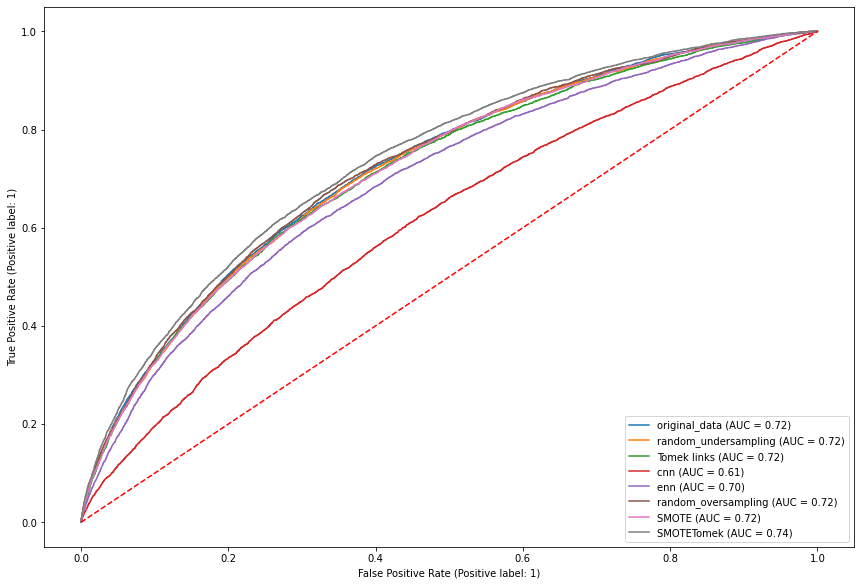

In [61]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
gbm1_disp = plot_roc_curve(gbm1, X_test, y_test,ax = ax, name = "original_data")
gbm2_disp = plot_roc_curve(gbm2, X_test, y_test,ax = ax, name = "random_undersampling")
gbm3_disp = plot_roc_curve(gbm3, X_test, y_test,ax = ax, name = "Tomek links")
gbm4_disp = plot_roc_curve(gbm4, X_test, y_test,ax = ax,name = "cnn")
gbm5_disp = plot_roc_curve(gbm5, X_test, y_test,ax= ax,name = "enn")
gbm6_disp = plot_roc_curve(gbm6, X_test, y_test,ax= ax,name = "random_oversampling")
gbm7_disp = plot_roc_curve(gbm7, X_test, y_test,ax= ax,name = "SMOTE")
gbm8_disp = plot_roc_curve(gbm8, X_test, y_test,ax= ax,name = "SMOTETomek")

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
plt.show()